In [1]:
import os
import string

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import keras_ocr

# Load dataset

In [2]:
DATASET_PATH = '../data/number-plate-benchmark-dataset' # source: https://github.com/MatiXOfficial/number-plate-benchmark-dataset

In [3]:
def load_image_paths(path):
    images = []
    for file_name in os.listdir(path):
        images.append(path + '/' + file_name)
    return images

def load_images(path):
    images = []
    for im_path in load_image_paths(path):
        image = keras_ocr.tools.read(im_path)
        images.append(image)
    return images

def load_plates(path):
    plates = []
    for file_name in os.listdir(path):
        df = pd.read_csv(path + '/' + file_name, header=None)
        file_plates = df.iloc[:, 0].values
        plates.append(file_plates)
    return plates

In [4]:
images = load_images(DATASET_PATH + '/images')
true_plates = load_plates(DATASET_PATH + '/plates')

len(images), len(true_plates)

(30, 30)

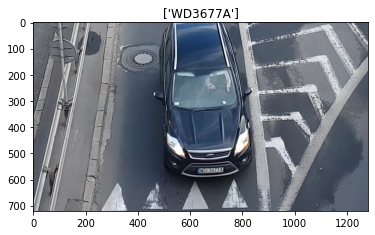

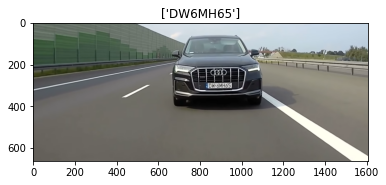

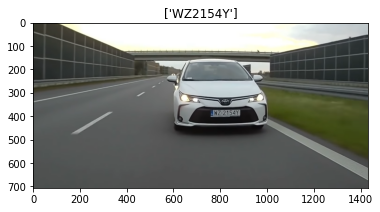

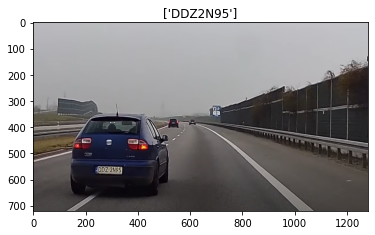

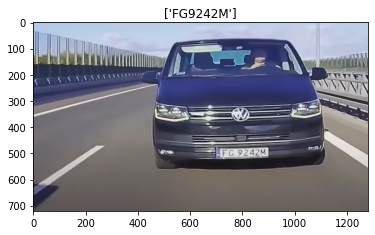

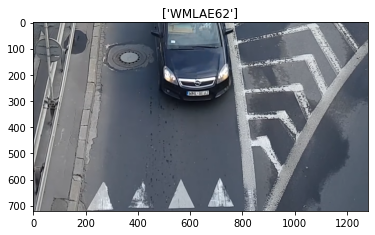

In [5]:
for i in range(0, 30, 5):
    plt.imshow(images[i])
    plt.title(true_plates[i])
    plt.show()

# Load model

In [6]:
detector = keras_ocr.detection.Detector()
recognizer = keras_ocr.recognition.Recognizer(alphabet=string.digits + string.ascii_uppercase)

detector.model.load_weights('../models/detector.h5')
recognizer.model.load_weights('../models/recognizer.h5')

pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)

Looking for C:\Users\MatiX\.keras-ocr\craft_mlt_25k.h5
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\MatiX\.keras-ocr\crnn_kurapan_notop.h5


# Benchmark

In [7]:
n_all_plates = sum(len(im_plates) for im_plates in true_plates)
n_all_plates

31

In [8]:
pred_plates = []
for image in images:
    prediction_groups = pipeline.recognize([image])
    image_pred_plates = [group[0] for group in prediction_groups[0]]
    pred_plates.append(image_pred_plates)
    
sum(len(im_plates) for im_plates in pred_plates)

64

In [9]:
synonym_letters = {
    'O': '0',
    '0': 'O'
}

def compare_plates(plate1, plate2):
    if len(plate1) != len(plate2):
        return False
    for p1, p2 in zip(plate1, plate2):
        if p1 != p2 and (p1 not in synonym_letters or synonym_letters[p1] != p2):
            return False
    return True

def is_plate_in(plate, cont):
    for el in cont:
        if compare_plates(el, plate):
            return True

In [10]:
n_positive = 0
for i, (im_pred_plates, im_true_plates) in enumerate(zip(pred_plates, true_plates)):
    n_im_positive = 0
    for pred in im_pred_plates:
        if is_plate_in(pred, im_true_plates):
            n_im_positive += 1
        
    print(f'Image {i+1:2}. Positively predicted {n_im_positive} out of {len(im_true_plates)}')
    n_positive += n_im_positive
    
n_positive

Image  1. Positively predicted 1 out of 1
Image  2. Positively predicted 0 out of 1
Image  3. Positively predicted 1 out of 1
Image  4. Positively predicted 1 out of 1
Image  5. Positively predicted 1 out of 1
Image  6. Positively predicted 1 out of 1
Image  7. Positively predicted 1 out of 1
Image  8. Positively predicted 1 out of 1
Image  9. Positively predicted 1 out of 1
Image 10. Positively predicted 1 out of 1
Image 11. Positively predicted 1 out of 1
Image 12. Positively predicted 0 out of 1
Image 13. Positively predicted 1 out of 1
Image 14. Positively predicted 0 out of 1
Image 15. Positively predicted 1 out of 1
Image 16. Positively predicted 1 out of 1
Image 17. Positively predicted 1 out of 1
Image 18. Positively predicted 1 out of 1
Image 19. Positively predicted 0 out of 1
Image 20. Positively predicted 1 out of 1
Image 21. Positively predicted 1 out of 1
Image 22. Positively predicted 0 out of 1
Image 23. Positively predicted 0 out of 1
Image 24. Positively predicted 1 o

21

In [11]:
print(f'Our accuracy = {n_positive / n_all_plates * 100:0.2f} %')

Our accuracy = 67.74 %


## Negative examples

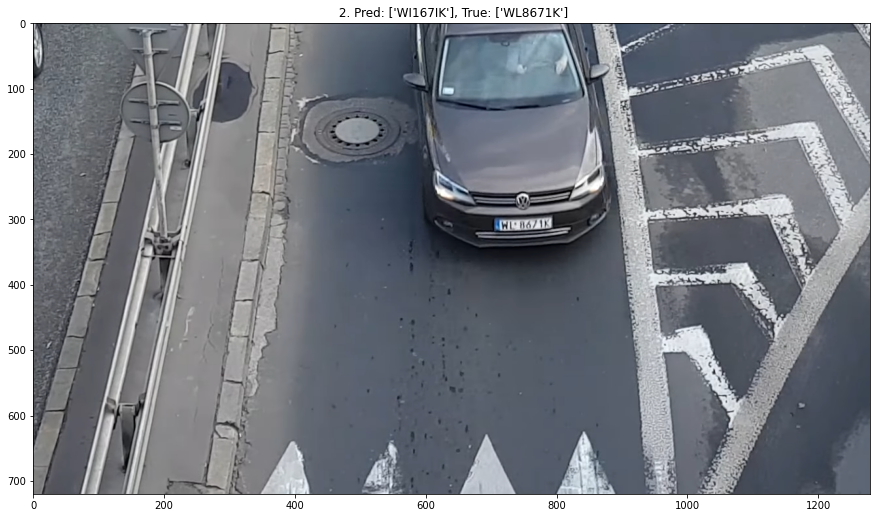

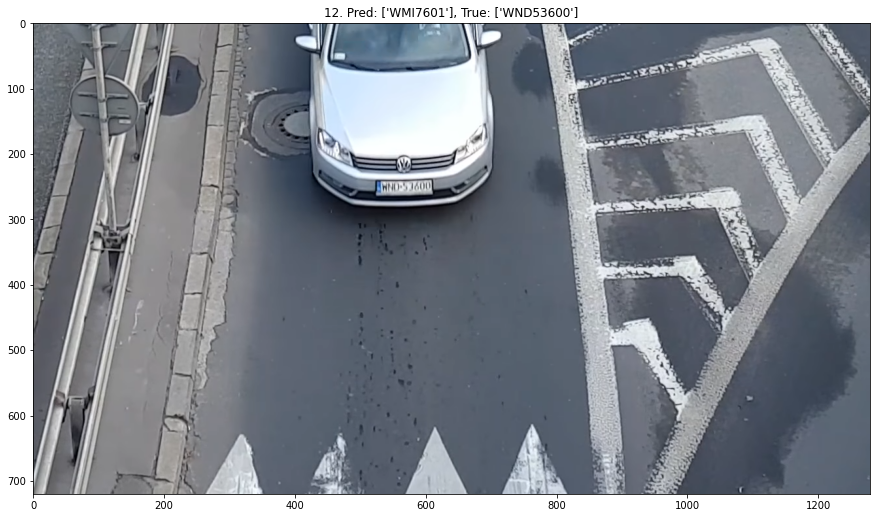

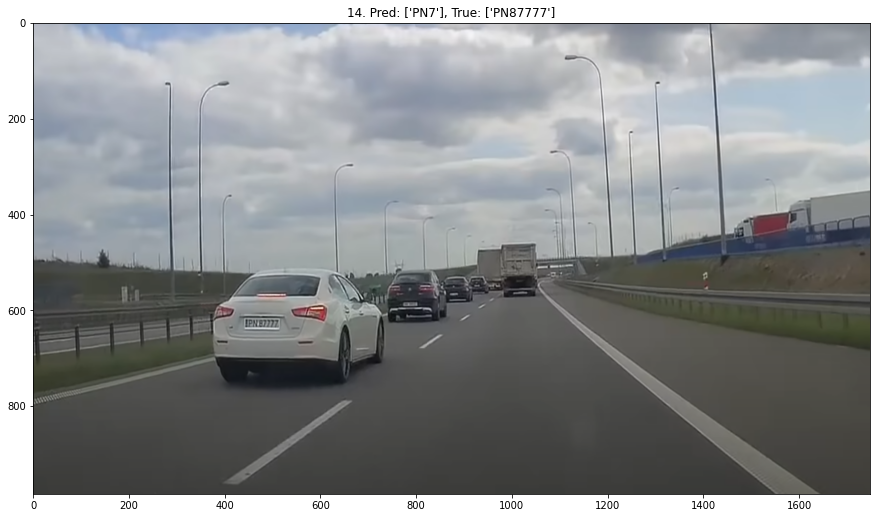

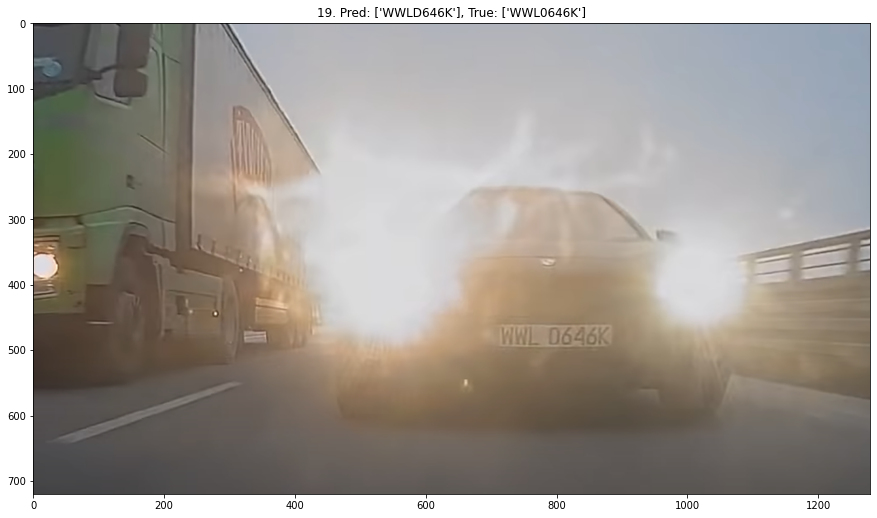

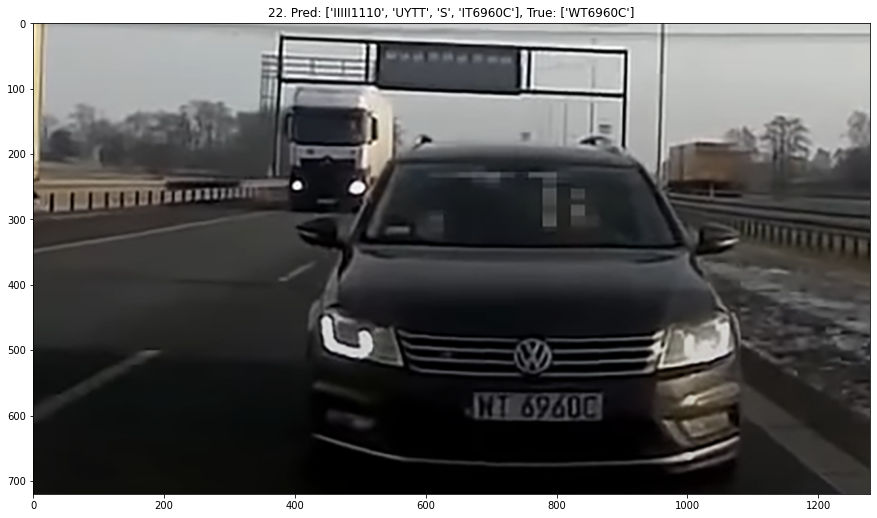

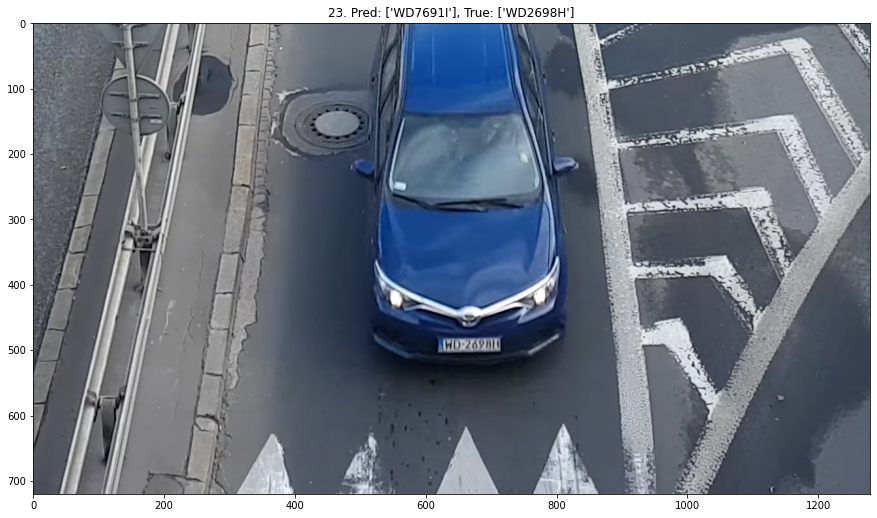

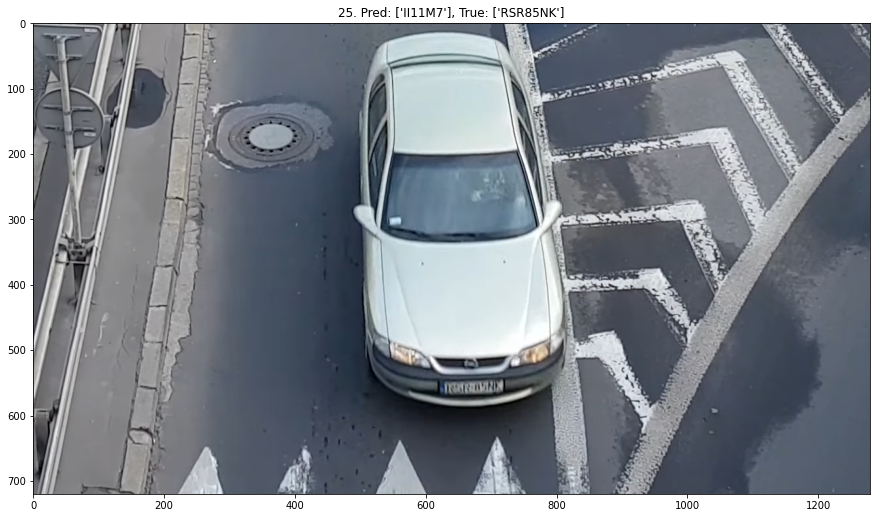

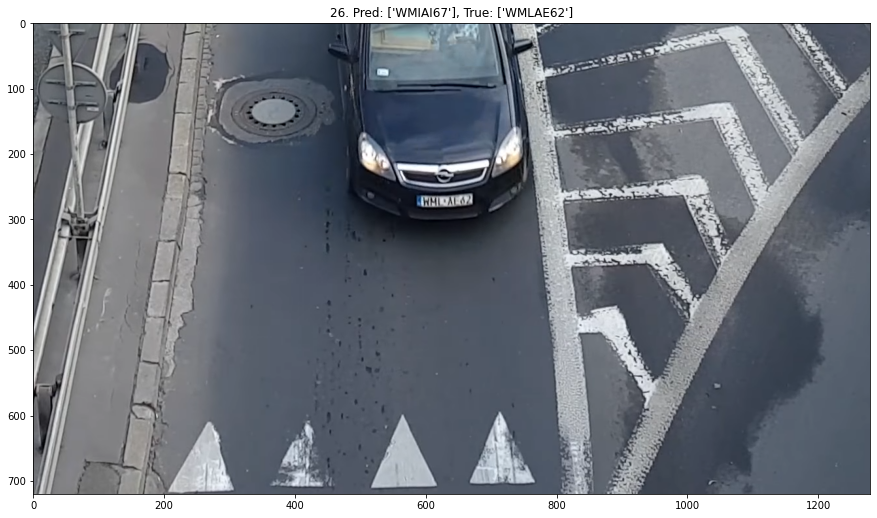

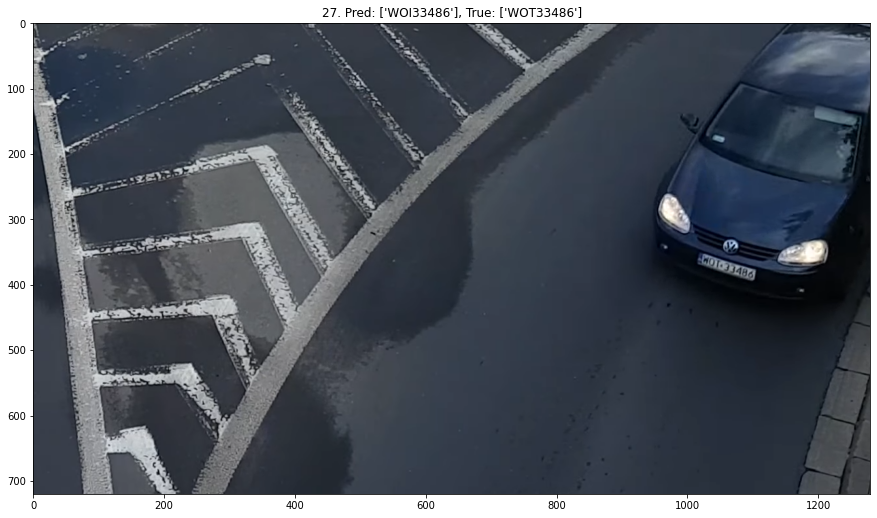

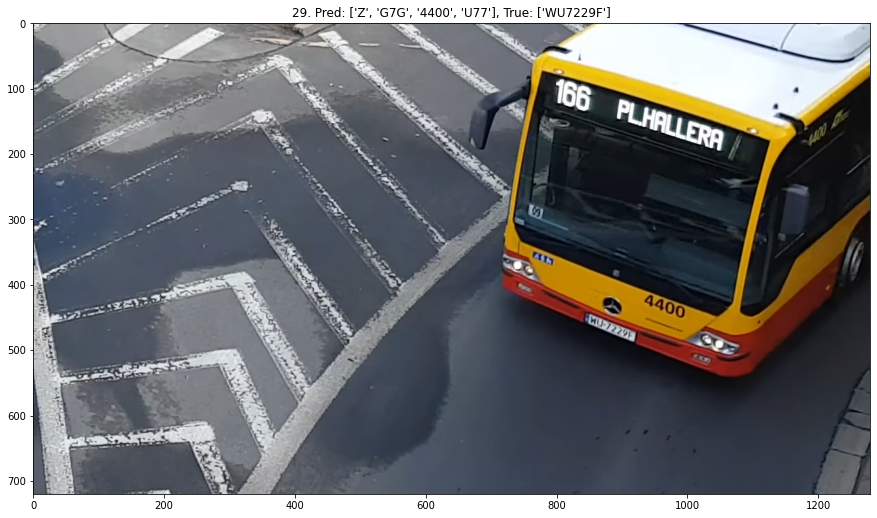

In [12]:
for i, (image, im_pred_plates, im_true_plates) in enumerate(zip(images, pred_plates, true_plates)):
    positive = all(is_plate_in(plate, im_pred_plates) for plate in im_true_plates)
    if not positive:
        plt.figure(figsize=(15, 10))
        plt.imshow(image)
        plt.title(f'{i + 1:2}. Pred: {im_pred_plates}, True: {im_true_plates}')
        plt.show()